# Thermal equilibrium

An ensemble of trajectories obtained from simulating Langevin dynamics will tend to a stable distribution: the Boltzmann distribution.

#### Problem setup

Two identical magnetic nanoparticles, aligned along their anisotropy axes. The system has 6 degrees of freedom (x,y,z components of magnetisation for each particle) but the energy is defined by the two angles $\theta_1,\theta_2$ alone.

![dimers](dimer-diagram.png)

#### Boltzmann distribution

The Boltzmann distribution represents the probabability that the system will be found within certain sets (i.e. the angles of magnetisation). The distribution is parameterised by the temperature of the system and the energy landscape of the problem.

Note the sine terms appear because the distribution is over the **solid angles**. In other words, the distribution is over the surface of a unit sphere. The sine terms project these solid angles onto a simple elevation angle between the magnetisation and the anisotropy axis ($\theta$).

$$p\left(\theta_1,\theta_2,\phi_1,\phi_2\right) = \frac{\sin(\theta_1)\sin(\theta_2)e^{-E\left(\theta_1,\theta_2,\phi_1,\phi_2\right)/\left(K_BT\right)}}{Z}$$

#### Stoner-Wohlfarth model

The energy function for a single domain magnetic nanoparticle is given by the Stoner-Wohlfarth equation:

$$\frac{E\left(\theta_1,\theta_2,\phi_1,\phi_2\right)}{K_BT}=\sigma\left(\sin^2\theta_1+\sin^2\theta_2\right)
-\nu\left[2\cos\theta_1\cos\theta_2 - \sin\theta_1\sin\theta_2\cos\left(\phi_1-\phi_2\right)\right]$$

$$\sigma=\frac{KV}{K_BT}$$

$$\nu=\frac{\mu_0V^2M_s^2}{2\pi R^3K_BT}$$

$\sigma,\nu$ are the normalised anisotropy and interaction strength respectively.

## Functions for analytic solution

In [1]:
import numpy as np

In [2]:
# dipole interaction energy
def dd(t1, t2, p1, p2, nu):
    return -nu*(2*np.cos(t1)*np.cos(t2) - np.sin(t1)*np.sin(t2)*np.cos(p1-p2))

# anisotropy energy
def anis(t1, t2, sigma):
    return sigma*(np.sin(t1)**2 + np.sin(t2)**2)

# total energy
def tot(t1, t2, p1, p2, nu, sigma):
    return dd(t1, t2, p1, p2, nu) + anis(t1, t2, sigma)

In [3]:
# numerator of the Boltzmann distribution (i.e. ignoring the partition function Z)
def p_unorm(t1,t2,p1,p2,nu,sigma):
    return np.sin(t1)*np.sin(t2)*np.exp(-tot(t1, t2, p1, p2, nu, sigma))

In [4]:
# non interacting
from scipy.integrate import nquad
sigma, nu = 1.0, 0.0

Z = nquad(
    lambda t1, t2, p1, p2: p_unorm(t1, t2, p1, p2, nu, sigma),
    ranges=[(0, np.pi), (0, np.pi), (0, 2*np.pi), (0, 2*np.pi)]
)
print(Z[0])

45.720674844308625


In [5]:
Z = nquad(
    lambda t1, t2: p_unorm(t1, t2, 0, 0, nu, sigma),
    ranges=[(0, np.pi), (0, np.pi)]
)
print(Z[0] * 4 * np.pi**2)

45.720674844308625


## Magpy non-interacting case

Using magpy we initialise the dimers with both magnetisation vectors aligned along their anisotropy axes. We allow the system to relax.

In [6]:
import magpy as mp

### System properties

Set up the parameters of the dimers. They are identical and aligned along their anisotropy axes

In [7]:
K = 1e5
r = 7e-9
T = 330
Ms=400e3
R=9e-9
kdir = [0, 0, 1]
location1 = np.array([0, 0, 0], dtype=np.float)
location2 = np.array([0, 0, R], dtype=np.float)
direction = np.array([0, 0, 1], dtype=np.float)
alpha = 1.0

### Magpy model and simulation 

Build a magpy model of the dimer

In [64]:
base_model = mp.Model(
    anisotropy=np.array([K, K], dtype=np.float),
    anisotropy_axis=np.array([kdir, kdir], dtype=np.float),
    damping=alpha,
    location=np.array([location1, location2], dtype=np.float),
    magnetisation=Ms,
    magnetisation_direction=np.array([direction, direction], dtype=np.float),
    radius=np.array([r, r], dtype=np.float),
    temperature=T
)
ensemble = mp.EnsembleModel(50000, base_model)

Simulate an ensemble of 10,000 dimers without interactions.

In [65]:
res = ensemble.simulate(end_time=1e-9, time_step=1e-12,
                        max_samples=500, random_state=1002,
                        n_jobs=8, implicit_solve=True,
                        interactions=False)
m_z0 = np.array([state['z'][0] for state in res.final_state()])/Ms
m_z1 = np.array([state['z'][1] for state in res.final_state()])/Ms
theta0 = np.arccos(m_z0)
theta1 = np.arccos(m_z1)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 536 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done 1040 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 1688 tasks      | elapsed:   15.9s
[Parallel(n_jobs=8)]: Done 2480 tasks      | elapsed:   23.4s
[Parallel(n_jobs=8)]: Done 3416 tasks      | elapsed:   32.1s
[Parallel(n_jobs=8)]: Done 4496 tasks      | elapsed:   42.9s
[Parallel(n_jobs=8)]: Done 5720 tasks      | elapsed:   55.1s
[Parallel(n_jobs=8)]: Done 7088 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 8600 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 10256 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 12056 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 14000 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 16088 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 18320 tasks      | elapsed:  2.9min
[Paral

System magnetisation shows that the system has relaxed into the local minima (we could relax the system globally but it would take much longer to run since the energy barrier must be overcome).

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

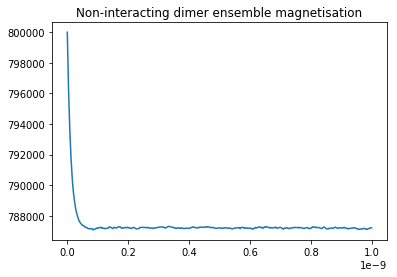

In [67]:
plt.plot(res.results[0].time, res.ensemble_magnetisation())
plt.title('Non-interacting dimer ensemble magnetisation');

### Compare to analytic thermal equilibrium

Compute the expected boltzmann distribution

In [68]:
# Dimensionless parameters
V = 4./3*np.pi*r**3
sigma = K*V/mp.core.get_KB()/T
nu = 0
print('Sigma: {:.3f}'.format(sigma))
print('   Nu: {:.3f}'.format(nu))

Sigma: 31.534
   Nu: 0.000


The joint distribution for both angles are computed analytically and compared with the numerical result.

The resulting distrubiton is symmetric because both particles are independent and identically distributed.

In [69]:
Z = nquad(
    lambda t1, t2, p1, p2: p_unorm(t1, t2, p1, p2, nu, sigma),
    ranges=[(0, np.pi/2), (0, np.pi/2), (0, 2*np.pi), (0, 2*np.pi)]
)
print(Z[0])
Z=Z[0]

0.01025875868541268


In [70]:
ts = np.linspace(min(theta0), max(theta0), 100)

In [71]:
bdist = [[
    nquad(lambda p1, p2: p_unorm(t1, t2, p1, p2, nu, sigma)/Z, ranges=[(0, 2*np.pi), (0, 2*np.pi)])[0]
    for t1 in ts]
for t2 in ts]

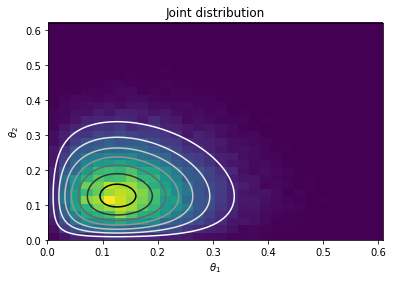

In [72]:
plt.hist2d(theta0, theta1, bins=30, normed=True);
plt.contour(ts, ts, bdist, cmap='Greys')
plt.title('Joint distribution')
plt.xlabel('$\\theta_1$'); plt.ylabel('$\\theta_2$');

We can also compute the marginal distribution (i.e. the equilibrium of just 1 particle). It is easier to see the alignment of the two distributions.

In [73]:
b_marginal = [nquad(
        lambda t2, p1, p2: p_unorm(t1, t2, p1, p2, nu, sigma)/Z,
        ranges=[(0, np.pi/2), (0, 2*np.pi), (0, 2*np.pi)])[0]
    for t1 in ts]

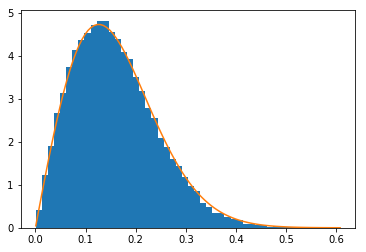

In [74]:
plt.hist(theta0, bins=50, normed=True)
plt.plot(ts, np.array(b_marginal))

## Magpy interacting case

We now simulate the exact same ensemble of dimers but with the interactions enabled. We can compute the dimensionless parameters to understand the strength of the interactions (vs. the anisotropy strength).

In [75]:
# Dimensionless parameters
V = 4./3*np.pi*r**3
sigma = K*V/mp.core.get_KB()/T
nu = mp.core.get_mu0() * V**2 * Ms**2 / 2.0 / np.pi**2 / R**3 / mp.core.get_KB() / T
print('Sigma: {:.3f}'.format(sigma))
print('   Nu: {:.3f}'.format(nu))

Sigma: 31.534
   Nu: 6.331


The interaction strength is very strong (actually the particles are impossibly close). The following command is identical to above except that `interactions=True`

In [76]:
res = ensemble.simulate(end_time=1e-9, time_step=1e-13,
                     max_samples=500, random_state=1001,
                     n_jobs=8, implicit_solve=False,
                     interactions=True, renorm=True)
m_z0i = np.array([state['z'][0] for state in res.final_state()])/Ms
m_z1i = np.array([state['z'][1] for state in res.final_state()])/Ms
theta0i = np.arccos(m_z0i)
theta1i = np.arccos(m_z1i)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 896 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 2876 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done 5648 tasks      | elapsed:   16.9s
[Parallel(n_jobs=8)]: Done 9212 tasks      | elapsed:   27.3s
[Parallel(n_jobs=8)]: Done 13568 tasks      | elapsed:   40.5s
[Parallel(n_jobs=8)]: Done 18716 tasks      | elapsed:   55.6s
[Parallel(n_jobs=8)]: Done 24656 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 31388 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 38912 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 47228 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:  2.5min finished


### System relaxation

The system quickly relaxes into the first minima again, as before.

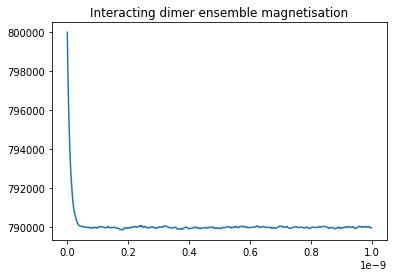

In [77]:
plt.plot(res.results[0].time, res.ensemble_magnetisation())
plt.title('Interacting dimer ensemble magnetisation');

### Thermal equilibrium

The stationary distributions align BUT:

**introduced fudge factor** of $\pi$ into the denominator of the interaction constant $\nu$. In other words we use $$\nu_\textrm{fudge}=\frac{\nu}{\pi}$$

This factor of $1/\pi$ could come from integrating somewhere. I *think* this is an error with my analytic calculations and not the code. This is because the code certainly uses the correct term for interaction strength, whereas I derived this test myself.

In [78]:
# Dimensionless parameters
V = 4./3*np.pi*r**3
sigma = K*V/mp.core.get_KB()/T
nu = 1.0 * mp.core.get_mu0() * V**2 * Ms**2 / 2.0 / np.pi / np.pi / R**3 / mp.core.get_KB() / T
print('Sigma: {:.3f}'.format(sigma))
print('   Nu: {:.3f}'.format(nu))

Sigma: 31.534
   Nu: 6.331


In [79]:
Z = nquad(
    lambda t1, t2, p1, p2: p_unorm(t1, t2, p1, p2, nu, sigma),
    ranges=[(0, np.pi/2), (0, np.pi/2), (0, 2*np.pi), (0, 2*np.pi)]
)[0]

In [80]:
ts = np.linspace(min(theta0), max(theta0), 100)
bdist = [[
    nquad(lambda p1, p2: p_unorm(t1, t2, p1, p2, nu, sigma)/Z, ranges=[(0, 2*np.pi), (0, 2*np.pi)])[0]
    for t1 in ts]
for t2 in ts]

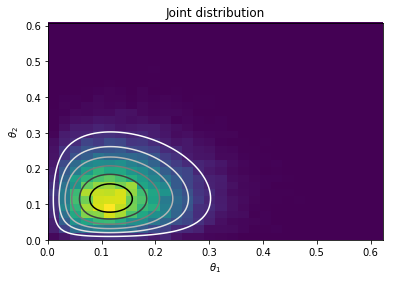

In [81]:
plt.hist2d(theta0i, theta1i, bins=30, normed=True);
# ts = np.linspace(min(theta0), max(theta0), 100)
# b = boltz_2d(ts, nu, sigma)
plt.contour(ts, ts, bdist, cmap='Greys')
plt.title('Joint distribution')
plt.xlabel('$\\theta_1$'); plt.ylabel('$\\theta_2$');

We use the marginal distribution again to check the convergence. We also compare to the interacting case

In [82]:
b_marginal = [nquad(
        lambda t2, p1, p2: p_unorm(t1, t2, p1, p2, nu, sigma)/Z,
        ranges=[(0, np.pi/2), (0, 2*np.pi), (0, 2*np.pi)])[0]
    for t1 in ts]

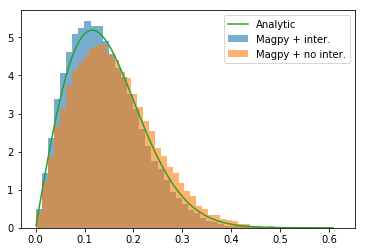

In [83]:
plt.hist(theta0i, bins=50, normed=True, alpha=0.6, label='Magpy + inter.')
plt.hist(theta0, bins=50, normed=True, alpha=0.6, label='Magpy + no inter.')
plt.plot(ts, b_marginal, label='Analytic')
plt.legend();

# Possible sources of error
 - Implementation of interaction strength in magpy (but there are many tests against the true equations)
 - Analytic calculations for equilibrium
 
One way to test this could be to simulate a 3D system. If another factor of $\pi$ appears then it is definitely something missing from my analytic calculations.

In [47]:
import pymc3 as pm

with pm.Model() as model:
    z1 = pm.Uniform('z1', 0, 1)
    theta1 = pm.Deterministic('theta1', np.arccos(z1))
    z2 = pm.Uniform('z2', 0, 1)
    theta2 = pm.Deterministic('theta2', np.arccos(z2))
    phi1 = pm.Uniform('phi1', 0, 2*np.pi)
    phi2 = pm.Uniform('phi2', 0, 2*np.pi)
    
    energy = tot(theta1, theta2, phi1, phi2, nu, sigma)
    
    like = pm.Potential('energy', -energy)

In [52]:
with model:
    step = pm.NUTS()
    trace = pm.sample(500000, step=step)

100%|█████████▉| 500446/500500 [07:58<00:00, 1045.08it/s]/home/owl/miniconda3/envs/magpy/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 325 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 500500/500500 [07:58<00:00, 1045.05it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f225fe201d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f22674847f0>]], dtype=object)

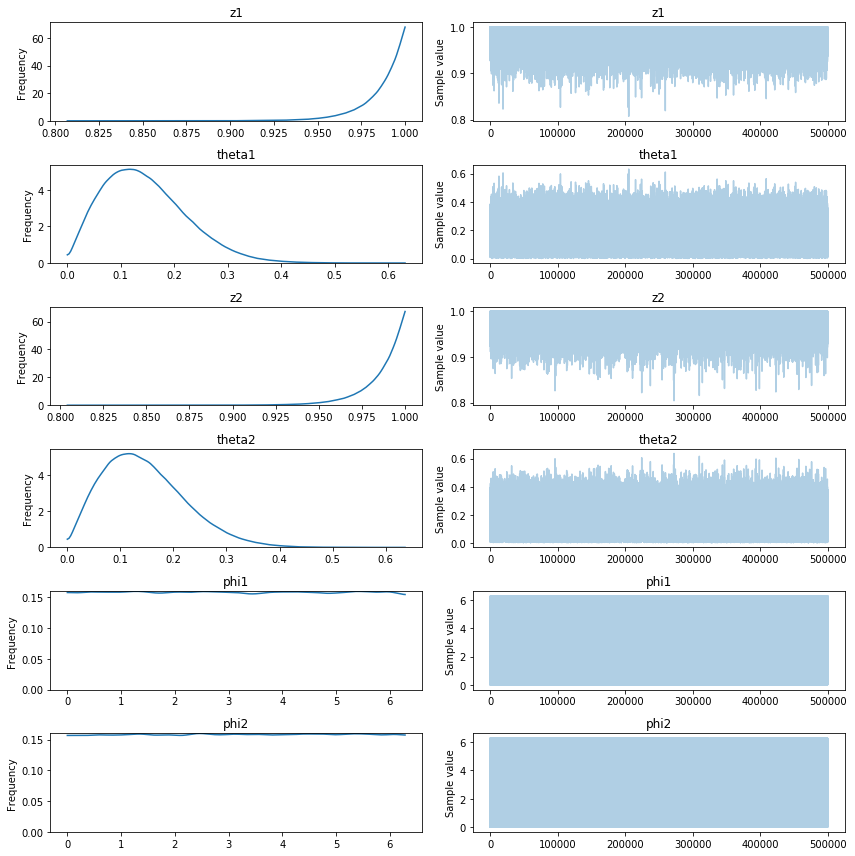

In [54]:
pm.traceplot(trace)

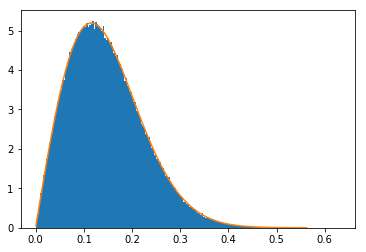

In [61]:
plt.hist(trace['theta1'], bins=200, normed=True);
plt.plot(ts, b_marginal, label='Analytic')

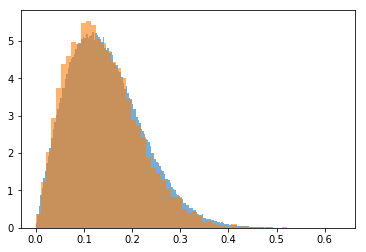

In [63]:
plt.hist(trace['theta1'], bins=200, normed=True, alpha=0.6);
plt.hist(theta0i, bins=50, normed=True, alpha=0.6, label='Magpy + inter.');

### Cartesian

In [ ]:
def cart_energy(mx1, my1, mz1, mx2, my2, my3, nu, sigma):
    t1 = np.arccos(mz1)
    t2 = np.arccos(mz2)
    anis = sigma*np.sin(t1)**2 + sigma*np.sin(t2)**2
    inter = -nu*(3*np.dot)

In [ ]:
import pymc3 as pm

with pm.Model() as model:
    z1 = pm.Uniform('z1', 0, 1)
    theta1 = pm.Deterministic('theta1', np.arccos(z1))
    z2 = pm.Uniform('z2', 0, 1)
    theta2 = pm.Deterministic('theta2', np.arccos(z2))
    phi1 = pm.Uniform('phi1', 0, 2*np.pi)
    phi2 = pm.Uniform('phi2', 0, 2*np.pi)
    
    energy = tot(theta1, theta2, phi1, phi2, nu, sigma)
    
    like = pm.Potential('energy', -energy)